In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_075_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_075_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1732 - acc: 0.2170
Epoch 00001: val_loss improved from inf to 2.31064, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_1_conv_checkpoint/001-2.3106.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 3.1731 - acc: 0.2169 - val_loss: 2.3106 - val_acc: 0.2453
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6976 - acc: 0.4808
Epoch 00002: val_loss did not improve from 2.31064
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.6975 - acc: 0.4809 - val_loss: 2.5730 - val_acc: 0.2902
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2834 - acc: 0.6030
Epoch 00003: val_loss did not improve from 2.31064
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.2834 - acc: 0.6030 - val_loss: 2.8633 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.1691 - acc: 0.9544
Epoch 00029: val_loss did not improve from 2.31064
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1691 - acc: 0.9544 - val_loss: 5.4253 - val_acc: 0.2914
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1570 - acc: 0.9554
Epoch 00030: val_loss did not improve from 2.31064
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1569 - acc: 0.9554 - val_loss: 5.5089 - val_acc: 0.2975
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1615 - acc: 0.9548
Epoch 00031: val_loss did not improve from 2.31064
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1615 - acc: 0.9548 - val_loss: 5.5001 - val_acc: 0.2972
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1598 - acc: 0.9562
Epoch 00032: val_loss did not improve from 2.31064
36805/36805 [========================

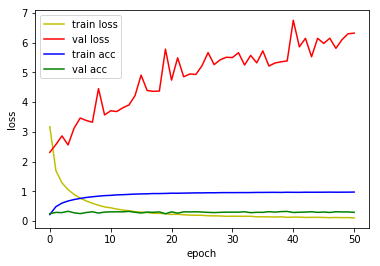

4815/4815 [==============================] - 2s 434us/sample - loss: 2.3570 - acc: 0.2318
Loss: 2.3570385051045957 Accuracy: 0.2317757

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3508 - acc: 0.2392
Epoch 00001: val_loss improved from inf to 2.69378, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_2_conv_checkpoint/001-2.6938.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 3.3510 - acc: 0.2392 - val_loss: 2.6938 - val_acc: 0.2569
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3447 - acc: 0.3797
Epoch 00002: val_loss improved from 2.69378 to 2.25107, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_2_conv_checkpoint/002-2.2511.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 2.3448 - acc: 0.3796 - val_loss: 2.2511 - val_acc: 0.3874
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.3004 - acc: 0.9098
Epoch 00029: val_loss did not improve from 2.25107
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.3006 - acc: 0.9098 - val_loss: 3.3433 - val_acc: 0.4428
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2762 - acc: 0.9160
Epoch 00030: val_loss did not improve from 2.25107
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.2762 - acc: 0.9160 - val_loss: 3.1137 - val_acc: 0.4621
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2697 - acc: 0.9172
Epoch 00031: val_loss did not improve from 2.25107
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.2697 - acc: 0.9172 - val_loss: 3.2268 - val_acc: 0.4694
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2531 - acc: 0.9238
Epoch 00032: val_loss did not improve from 2.25107
36805/36805 [========================

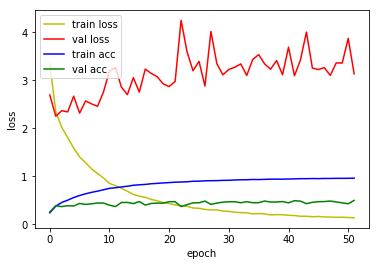

4815/4815 [==============================] - 3s 718us/sample - loss: 2.3558 - acc: 0.3616
Loss: 2.3557704696526534 Accuracy: 0.3615784

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7274 - acc: 0.2832
Epoch 00001: val_loss improved from inf to 1.91350, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_3_conv_checkpoint/001-1.9135.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.7272 - acc: 0.2832 - val_loss: 1.9135 - val_acc: 0.3811
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9395 - acc: 0.4385
Epoch 00002: val_loss improved from 1.91350 to 1.53119, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_3_conv_checkpoint/002-1.5312.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss: 1.9395 - acc: 0.4384 - val_loss: 1.5312 - val_acc: 0.5181
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3880 - acc: 0.8737
Epoch 00028: val_loss did not improve from 1.26514
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.3881 - acc: 0.8737 - val_loss: 1.4471 - val_acc: 0.6629
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3748 - acc: 0.8769
Epoch 00029: val_loss did not improve from 1.26514
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.3749 - acc: 0.8768 - val_loss: 1.3971 - val_acc: 0.6734
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3545 - acc: 0.8834
Epoch 00030: val_loss did not improve from 1.26514
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.3545 - acc: 0.8834 - val_loss: 1.5819 - val_acc: 0.6366
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3555 - acc: 0.8831
Epoch 00031: val_loss did not improve from 1.26514
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1935 - acc: 0.9364
Epoch 00058: val_loss did not improve from 1.26514
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.1935 - acc: 0.9364 - val_loss: 1.3210 - val_acc: 0.7074
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1747 - acc: 0.9428
Epoch 00059: val_loss did not improve from 1.26514
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.1748 - acc: 0.9428 - val_loss: 1.4388 - val_acc: 0.6797
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1732 - acc: 0.9453
Epoch 00060: val_loss did not improve from 1.26514
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.1732 - acc: 0.9453 - val_loss: 1.8509 - val_acc: 0.6215
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1734 - acc: 0.9438
Epoch 00061: val_loss did not improve from 1.26514
36805/36805 [===========

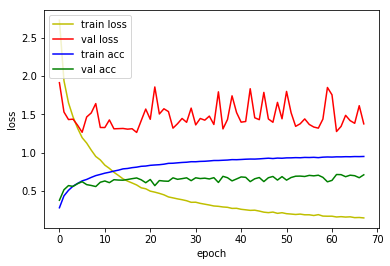

4815/4815 [==============================] - 4s 807us/sample - loss: 1.4029 - acc: 0.6309
Loss: 1.4029251341755393 Accuracy: 0.63094497

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8424 - acc: 0.2676
Epoch 00001: val_loss improved from inf to 1.81628, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_4_conv_checkpoint/001-1.8163.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.8426 - acc: 0.2675 - val_loss: 1.8163 - val_acc: 0.3981
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8526 - acc: 0.4559
Epoch 00002: val_loss improved from 1.81628 to 1.27767, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_4_conv_checkpoint/002-1.2777.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.8526 - acc: 0.4558 - val_loss: 1.2777 - val_acc: 0.6215
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.5165 - acc: 0.8357
Epoch 00026: val_loss did not improve from 0.77763
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.5165 - acc: 0.8356 - val_loss: 0.9720 - val_acc: 0.7307
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5048 - acc: 0.8394
Epoch 00027: val_loss improved from 0.77763 to 0.75888, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_4_conv_checkpoint/027-0.7589.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.5048 - acc: 0.8394 - val_loss: 0.7589 - val_acc: 0.7897
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4819 - acc: 0.8458
Epoch 00028: val_loss did not improve from 0.75888
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.4820 - acc: 0.8458 - val_loss: 0.7841 - val_acc: 0.7747
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4671 - a

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2930 - acc: 0.9043
Epoch 00054: val_loss did not improve from 0.68591
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2930 - acc: 0.9043 - val_loss: 0.7223 - val_acc: 0.8104
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2932 - acc: 0.9033
Epoch 00055: val_loss did not improve from 0.68591
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2932 - acc: 0.9033 - val_loss: 0.7096 - val_acc: 0.8169
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2878 - acc: 0.9049
Epoch 00056: val_loss did not improve from 0.68591
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2878 - acc: 0.9049 - val_loss: 0.7756 - val_acc: 0.7973
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2832 - acc: 0.9088
Epoch 00057: val_loss did not improve from 0.68591
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2058 - acc: 0.9325
Epoch 00084: val_loss did not improve from 0.68591
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2058 - acc: 0.9325 - val_loss: 0.7793 - val_acc: 0.7999
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2019 - acc: 0.9338
Epoch 00085: val_loss did not improve from 0.68591
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2019 - acc: 0.9338 - val_loss: 0.7154 - val_acc: 0.8272
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2036 - acc: 0.9326
Epoch 00086: val_loss did not improve from 0.68591
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2036 - acc: 0.9326 - val_loss: 0.8051 - val_acc: 0.8088

1D_CNN_custom_DO_075_DO_BN_4_conv Model


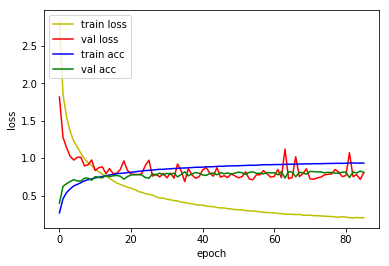

4815/4815 [==============================] - 4s 844us/sample - loss: 0.8081 - acc: 0.7718
Loss: 0.8080774210447587 Accuracy: 0.7717549

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8994 - acc: 0.2595
Epoch 00001: val_loss improved from inf to 2.04151, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_5_conv_checkpoint/001-2.0415.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.8996 - acc: 0.2595 - val_loss: 2.0415 - val_acc: 0.3240
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7718 - acc: 0.4809
Epoch 00002: val_loss improved from 2.04151 to 1.16538, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_5_conv_checkpoint/002-1.1654.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.7717 - acc: 0.4809 - val_loss: 1.1654 - val_acc: 0.6553
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.5093 - acc: 0.8427
Epoch 00025: val_loss did not improve from 0.56496
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.5092 - acc: 0.8427 - val_loss: 0.6134 - val_acc: 0.8246
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4965 - acc: 0.8466
Epoch 00026: val_loss did not improve from 0.56496
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.4965 - acc: 0.8466 - val_loss: 0.7134 - val_acc: 0.8053
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4820 - acc: 0.8514
Epoch 00027: val_loss did not improve from 0.56496
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.4821 - acc: 0.8513 - val_loss: 0.5888 - val_acc: 0.8323
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4724 - acc: 0.8548
Epoch 00028: val_loss did not improve from 0.56496
36805/36805 [========================

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2880 - acc: 0.9062
Epoch 00053: val_loss did not improve from 0.49577
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2881 - acc: 0.9062 - val_loss: 0.5259 - val_acc: 0.8628
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2922 - acc: 0.9057
Epoch 00054: val_loss did not improve from 0.49577
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2922 - acc: 0.9056 - val_loss: 0.5020 - val_acc: 0.8630
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2823 - acc: 0.9088
Epoch 00055: val_loss did not improve from 0.49577
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.2824 - acc: 0.9088 - val_loss: 0.5586 - val_acc: 0.8495
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2791 - acc: 0.9108
Epoch 00056: val_loss did not improve from 0.49577
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1940 - acc: 0.9364
Epoch 00082: val_loss did not improve from 0.48977
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1940 - acc: 0.9364 - val_loss: 0.6073 - val_acc: 0.8560
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1915 - acc: 0.9378
Epoch 00083: val_loss did not improve from 0.48977
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1915 - acc: 0.9378 - val_loss: 0.5212 - val_acc: 0.8682
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1840 - acc: 0.9414
Epoch 00084: val_loss did not improve from 0.48977
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1840 - acc: 0.9414 - val_loss: 0.5101 - val_acc: 0.8765
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1899 - acc: 0.9382
Epoch 00085: val_loss did not improve from 0.48977
36805/36805 [========================

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1494 - acc: 0.9513
Epoch 00112: val_loss did not improve from 0.48977
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1494 - acc: 0.9513 - val_loss: 0.5026 - val_acc: 0.8819
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1428 - acc: 0.9545
Epoch 00113: val_loss did not improve from 0.48977
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1429 - acc: 0.9545 - val_loss: 0.7789 - val_acc: 0.8262
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1528 - acc: 0.9514
Epoch 00114: val_loss did not improve from 0.48977
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1528 - acc: 0.9514 - val_loss: 0.5023 - val_acc: 0.8826
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1422 - acc: 0.9551
Epoch 00115: val_loss did not improve from 0.48977
36805/36805 [=======

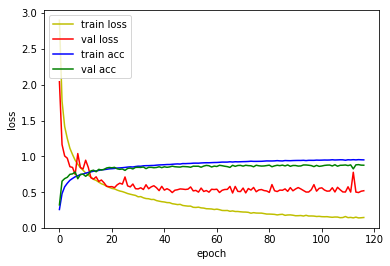

4815/4815 [==============================] - 4s 886us/sample - loss: 0.6022 - acc: 0.8355
Loss: 0.6022437252359598 Accuracy: 0.835514

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8975 - acc: 0.2145
Epoch 00001: val_loss improved from inf to 1.76617, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_6_conv_checkpoint/001-1.7662.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 2.8976 - acc: 0.2145 - val_loss: 1.7662 - val_acc: 0.4181
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7847 - acc: 0.4515
Epoch 00002: val_loss improved from 1.76617 to 1.09709, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_6_conv_checkpoint/002-1.0971.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.7846 - acc: 0.4515 - val_loss: 1.0971 - val_acc: 0.6613
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.4072 - acc: 0.8760
Epoch 00024: val_loss did not improve from 0.39413
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.4073 - acc: 0.8760 - val_loss: 0.5042 - val_acc: 0.8661
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3977 - acc: 0.8801
Epoch 00025: val_loss did not improve from 0.39413
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3977 - acc: 0.8801 - val_loss: 0.3942 - val_acc: 0.8924
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3939 - acc: 0.8810
Epoch 00026: val_loss improved from 0.39413 to 0.38309, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_6_conv_checkpoint/026-0.3831.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3938 - acc: 0.8810 - val_loss: 0.3831 - val_acc: 0.8973
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3763 - a

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2390 - acc: 0.9244
Epoch 00052: val_loss did not improve from 0.33358
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2389 - acc: 0.9244 - val_loss: 0.3604 - val_acc: 0.9106
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2304 - acc: 0.9273
Epoch 00053: val_loss did not improve from 0.33358
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2303 - acc: 0.9273 - val_loss: 0.3538 - val_acc: 0.9092
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2241 - acc: 0.9275
Epoch 00054: val_loss did not improve from 0.33358
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2240 - acc: 0.9275 - val_loss: 0.3760 - val_acc: 0.9015
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2248 - acc: 0.9276
Epoch 00055: val_loss did not improve from 0.33358
36805/36805 [===========

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1598 - acc: 0.9478
Epoch 00081: val_loss did not improve from 0.30027
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1599 - acc: 0.9478 - val_loss: 0.3571 - val_acc: 0.9171
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1578 - acc: 0.9491
Epoch 00082: val_loss did not improve from 0.30027
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1579 - acc: 0.9491 - val_loss: 0.3448 - val_acc: 0.9133
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1566 - acc: 0.9488
Epoch 00083: val_loss did not improve from 0.30027
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1566 - acc: 0.9488 - val_loss: 0.3252 - val_acc: 0.9175
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1521 - acc: 0.9500
Epoch 00084: val_loss did not improve from 0.30027
36805/36805 [===========

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1176 - acc: 0.9619
Epoch 00111: val_loss did not improve from 0.30027
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1176 - acc: 0.9619 - val_loss: 0.4345 - val_acc: 0.9078
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1158 - acc: 0.9618
Epoch 00112: val_loss did not improve from 0.30027
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1158 - acc: 0.9618 - val_loss: 0.3263 - val_acc: 0.9196
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1113 - acc: 0.9630
Epoch 00113: val_loss did not improve from 0.30027
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1113 - acc: 0.9630 - val_loss: 0.3785 - val_acc: 0.9133
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1112 - acc: 0.9640
Epoch 00114: val_loss did not improve from 0.30027
36805/36805 [=======

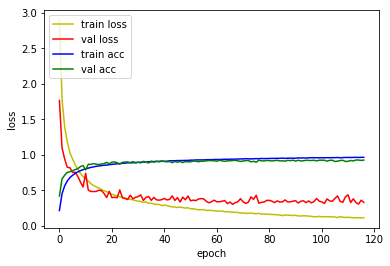

4815/4815 [==============================] - 5s 941us/sample - loss: 0.3867 - acc: 0.8933
Loss: 0.38665750389406117 Accuracy: 0.8932503

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1795 - acc: 0.1709
Epoch 00001: val_loss improved from inf to 1.98156, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_7_conv_checkpoint/001-1.9816.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 3.1795 - acc: 0.1709 - val_loss: 1.9816 - val_acc: 0.3590
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0280 - acc: 0.3683
Epoch 00002: val_loss improved from 1.98156 to 1.27779, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_7_conv_checkpoint/002-1.2778.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 2.0281 - acc: 0.3683 - val_loss: 1.2778 - val_acc: 0.6082
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2957 - acc: 0.9079
Epoch 00024: val_loss improved from 0.27554 to 0.25567, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_7_conv_checkpoint/024-0.2557.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2957 - acc: 0.9079 - val_loss: 0.2557 - val_acc: 0.9313
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2884 - acc: 0.9105
Epoch 00025: val_loss did not improve from 0.25567
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2885 - acc: 0.9104 - val_loss: 0.3343 - val_acc: 0.9119
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2848 - acc: 0.9126
Epoch 00026: val_loss did not improve from 0.25567
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2848 - acc: 0.9126 - val_loss: 0.2779 - val_acc: 0.9234
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.1471 - acc: 0.9526
Epoch 00052: val_loss did not improve from 0.19780
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1471 - acc: 0.9526 - val_loss: 0.2619 - val_acc: 0.9334
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1418 - acc: 0.9545
Epoch 00053: val_loss did not improve from 0.19780
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1417 - acc: 0.9545 - val_loss: 0.2327 - val_acc: 0.9415
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1431 - acc: 0.9535
Epoch 00054: val_loss did not improve from 0.19780
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1430 - acc: 0.9535 - val_loss: 0.2290 - val_acc: 0.9436
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1380 - acc: 0.9550
Epoch 00055: val_loss did not improve from 0.19780
36805/36805 [========================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9713
Epoch 00082: val_loss did not improve from 0.19454
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0878 - acc: 0.9713 - val_loss: 0.2713 - val_acc: 0.9432
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0915 - acc: 0.9701
Epoch 00083: val_loss did not improve from 0.19454
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0915 - acc: 0.9701 - val_loss: 0.2357 - val_acc: 0.9446
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0860 - acc: 0.9720
Epoch 00084: val_loss did not improve from 0.19454
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0861 - acc: 0.9720 - val_loss: 0.2450 - val_acc: 0.9397
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0898 - acc: 0.9705
Epoch 00085: val_loss did not improve from 0.19454
36805/36805 [===========

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0691 - acc: 0.9782
Epoch 00112: val_loss did not improve from 0.19454
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0692 - acc: 0.9781 - val_loss: 0.2516 - val_acc: 0.9450

1D_CNN_custom_DO_075_DO_BN_7_conv Model


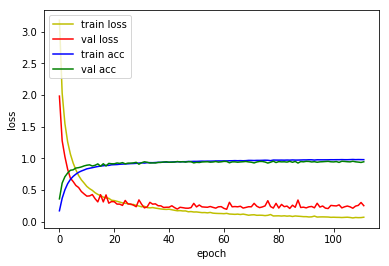

4815/4815 [==============================] - 5s 991us/sample - loss: 0.2401 - acc: 0.9354
Loss: 0.24014565102670918 Accuracy: 0.9354102

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2123 - acc: 0.1758
Epoch 00001: val_loss improved from inf to 1.88975, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_8_conv_checkpoint/001-1.8898.hdf5
36805/36805 [==============================] - 105s 3ms/sample - loss: 3.2124 - acc: 0.1758 - val_loss: 1.8898 - val_acc: 0.4512
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0172 - acc: 0.3753
Epoch 00002: val_loss improved from 1.88975 to 1.10019, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_8_conv_checkpoint/002-1.1002.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 2.0173 - acc: 0.3753 - val_loss: 1.1002 - val_acc: 0.6862
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1961 - acc: 0.9384
Epoch 00024: val_loss did not improve from 0.16280
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1961 - acc: 0.9384 - val_loss: 0.2132 - val_acc: 0.9362
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1902 - acc: 0.9403
Epoch 00025: val_loss improved from 0.16280 to 0.15219, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_8_conv_checkpoint/025-0.1522.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1902 - acc: 0.9403 - val_loss: 0.1522 - val_acc: 0.9543
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1798 - acc: 0.9445
Epoch 00026: val_loss did not improve from 0.15219
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1799 - acc: 0.9445 - val_loss: 0.1529 - val_acc: 0.9539
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1757 - a

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0846 - acc: 0.9724
Epoch 00053: val_loss did not improve from 0.12670
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0846 - acc: 0.9724 - val_loss: 0.1922 - val_acc: 0.9515
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0742 - acc: 0.9760
Epoch 00054: val_loss did not improve from 0.12670
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0742 - acc: 0.9760 - val_loss: 0.1449 - val_acc: 0.9625
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0720 - acc: 0.9775
Epoch 00055: val_loss did not improve from 0.12670
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0719 - acc: 0.9775 - val_loss: 0.1836 - val_acc: 0.9539
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0686 - acc: 0.9785
Epoch 00056: val_loss did not improve from 0.12670
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9868
Epoch 00083: val_loss did not improve from 0.12670
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0403 - acc: 0.9868 - val_loss: 0.2218 - val_acc: 0.9534
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9854
Epoch 00084: val_loss did not improve from 0.12670
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0465 - acc: 0.9854 - val_loss: 0.1755 - val_acc: 0.9604
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9887
Epoch 00085: val_loss did not improve from 0.12670
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0366 - acc: 0.9887 - val_loss: 0.1614 - val_acc: 0.9620
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9880
Epoch 00086: val_loss did not improve from 0.12670
36805/36805 [===========

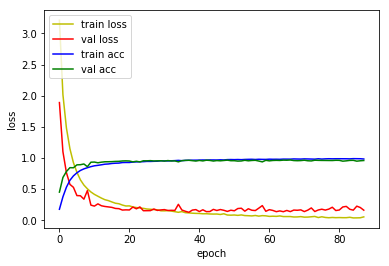

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1735 - acc: 0.9493
Loss: 0.17354647725325384 Accuracy: 0.949325

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9782 - acc: 0.2824
Epoch 00001: val_loss improved from inf to 1.41508, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_9_conv_checkpoint/001-1.4151.hdf5
36805/36805 [==============================] - 110s 3ms/sample - loss: 2.9780 - acc: 0.2825 - val_loss: 1.4151 - val_acc: 0.5763
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4162 - acc: 0.5791
Epoch 00002: val_loss improved from 1.41508 to 0.57773, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_9_conv_checkpoint/002-0.5777.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.4164 - acc: 0.5791 - val_loss: 0.5777 - val_acc: 0.8314
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0998 - acc: 0.9683
Epoch 00025: val_loss improved from 0.12600 to 0.12544, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_9_conv_checkpoint/025-0.1254.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0998 - acc: 0.9683 - val_loss: 0.1254 - val_acc: 0.9630
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0966 - acc: 0.9692
Epoch 00026: val_loss did not improve from 0.12544
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0966 - acc: 0.9692 - val_loss: 0.1343 - val_acc: 0.9611
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0870 - acc: 0.9737
Epoch 00027: val_loss improved from 0.12544 to 0.10666, saving model to model/checkpoint/1D_CNN_custom_DO_075_DO_BN_9_conv_checkpoint/027-0.1067.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0870 - acc: 0.9737 - val_loss:

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9893
Epoch 00054: val_loss did not improve from 0.10666
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0340 - acc: 0.9893 - val_loss: 0.1323 - val_acc: 0.9641
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9920
Epoch 00055: val_loss did not improve from 0.10666
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0267 - acc: 0.9920 - val_loss: 0.1334 - val_acc: 0.9674
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9918
Epoch 00056: val_loss did not improve from 0.10666
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0268 - acc: 0.9917 - val_loss: 0.1670 - val_acc: 0.9611
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9886
Epoch 00057: val_loss did not improve from 0.10666
36805/36805 [===========

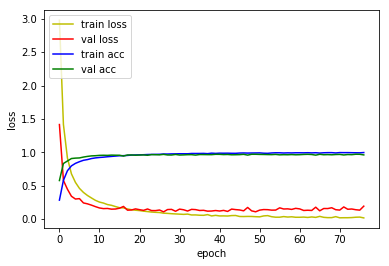

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1693 - acc: 0.9470
Loss: 0.16931005258979673 Accuracy: 0.9470405



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_DO_075_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_075_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_DO_075_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_075_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
_____________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.8081 - acc: 0.7718
Loss: 0.8080774210447587 Accuracy: 0.7717549

1D_CNN_custom_DO_075_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (None

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2401 - acc: 0.9354
Loss: 0.24014565102670918 Accuracy: 0.9354102

1D_CNN_custom_DO_075_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (Non

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1693 - acc: 0.9470
Loss: 0.16931005258979673 Accuracy: 0.9470405
